In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
from cuml import ForestInference
import sys
from tqdm import tqdm
import os
import random
from glob import glob
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric

In [2]:
config = f"""
execution:
    exp_id: exp_002
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    10min_csv_dir: /kaggle/input/save_10min_csvs/pred_10min_csvs

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

## 特徴生成

In [3]:
def generate_features(train: pd.DataFrame):
    features = {}
    if train.shape[0] == 0:
        return train, features
    
    # not for pred
    features["series_id"] = train["series_id"].values[0]
    features["step_min"] = train["step"].min()
    features["step_max"] = train["step"].max()
    if "target" in train.columns:
        features["target"] = train["target"].mean() > 0.5 

    # features
    timestamp = pd.to_datetime(train["timestamp"].values[0])
    features["total_seconds"] = (timestamp - timestamp.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()

    # センサの統計量
    for c in ["anglez", "enmo"]:
        features[f"{c}_mean"] = train[c].mean()
        features[f"{c}_median"] = train[c].median()
        features[f"{c}_max"] = train[c].max()
        features[f"{c}_min"] = train[c].min()
        features[f"{c}_std"] = train[c].std()
        features[f"{c}_square_mean"] = (train[c] ** 2).mean()

    return train, features

def read_and_generate_features(file):
    train = pd.read_csv(file)
    train, features = generate_features(train)
    return features

In [4]:
files = glob(f"{CFG['dataset']['10min_csv_dir']}/*/*.csv")

if CFG["execution"]["multiprocessing"]:
    with Pool(30) as pool:
        all_features = list(tqdm(pool.imap(read_and_generate_features, files), total=len(files)))
else:
    all_features = []
    for file in tqdm(files):
        train = pd.read_csv(file)
        train, features = generate_features(train)
        all_features.append(features)

features = set().union(*[d.keys() for d in all_features]) - {"series_id", "step_min", "step_max", "target"}
train = pd.DataFrame(all_features)

100%|██████████| 1066362/1066362 [02:15<00:00, 7886.93it/s]


## 学習

In [5]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train = train.merge(cv_split, on=["series_id"], how="left")
train.head(5)

,series_id,step_min,step_max,target,total_seconds,anglez_mean,anglez_median,anglez_max,anglez_min,anglez_std,anglez_square_mean,enmo_mean,enmo_median,enmo_max,enmo_min,enmo_std,enmo_square_mean,fold
0,612aa8ba44e2,268740,268859,True,14400.0,-47.146022,-47.83980,-37.3546,-48.5107,1.948389,2226.511943,0.002045,0.0007,0.1001,0.0000,0.009972,1.027883e-04,3
1,612aa8ba44e2,154020,154139,True,45600.0,-86.943919,-86.95065,-86.8061,-87.0715,0.087503,7559.252673,0.000826,0.0008,0.0014,0.0004,0.000238,7.382500e-07,3
2,612aa8ba44e2,371100,371219,True,7800.0,-10.059685,-12.43370,1.2050,-20.6778,5.976369,136.616611,0.005124,0.0045,0.0200,0.0017,0.003256,3.676725e-05,3
3,612aa8ba44e2,391860,391979,True,25200.0,0.812441,1.23605,8.0100,-10.5224,4.125580,17.538632,0.006171,0.0055,0.0145,0.0025,0.002380,4.369758e-05,3
4,612aa8ba44e2,153300,153419,True,42000.0,-87.034232,-87.03300,-87.0330,-87.0448,0.002442,7574.957633,0.000491,0.0005,0.0006,0.0003,0.000082,2.475833e-07,3


In [6]:
if CFG['execution']['submit']:
    # 推論
    models = [
        ForestInference.load(
            os.path.join(CFG["model_dir"], f'xgb_fold{i}.model'),
            output_class=True,
            model_type='xgboost'
        ) for i in range(CFG.n_fold)]
    pred = inference_xgb(models, train[features])
else:
    # 学習
    trn_oof, models = fit_xgb(train[features], train["target"], train["fold"].astype(
        int), params=CFG["xgboost"], es_rounds=50)
    train["oof"] = trn_oof

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-logloss:0.63082
[50]	eval-logloss:0.19918
[100]	eval-logloss:0.19253
[150]	eval-logloss:0.19017
[200]	eval-logloss:0.18882
[250]	eval-logloss:0.18843
[300]	eval-logloss:0.18830
[350]	eval-logloss:0.18834
[382]	eval-logloss:0.18830


 20%|██        | 1/5 [00:34<02:18, 34.66s/it]

== fold 1 ==
[0]	eval-logloss:0.63032
[50]	eval-logloss:0.20520
[100]	eval-logloss:0.19671
[150]	eval-logloss:0.19299
[200]	eval-logloss:0.19118
[250]	eval-logloss:0.19053
[300]	eval-logloss:0.18988
[350]	eval-logloss:0.18898
[400]	eval-logloss:0.18878
[450]	eval-logloss:0.18829
[500]	eval-logloss:0.18808
[550]	eval-logloss:0.18789
[600]	eval-logloss:0.18768
[650]	eval-logloss:0.18778
[664]	eval-logloss:0.18776


 40%|████      | 2/5 [01:32<02:25, 48.46s/it]

== fold 2 ==
[0]	eval-logloss:0.63043
[50]	eval-logloss:0.18749
[100]	eval-logloss:0.17742
[150]	eval-logloss:0.17415
[200]	eval-logloss:0.17238
[250]	eval-logloss:0.17106
[300]	eval-logloss:0.17013
[350]	eval-logloss:0.16972
[400]	eval-logloss:0.16935
[450]	eval-logloss:0.16887
[500]	eval-logloss:0.16818
[550]	eval-logloss:0.16783
[600]	eval-logloss:0.16754
[650]	eval-logloss:0.16739
[700]	eval-logloss:0.16736
[719]	eval-logloss:0.16739


 60%|██████    | 3/5 [02:36<01:50, 55.33s/it]

== fold 3 ==
[0]	eval-logloss:0.63151
[50]	eval-logloss:0.23491
[100]	eval-logloss:0.23009
[150]	eval-logloss:0.22823
[200]	eval-logloss:0.22703
[250]	eval-logloss:0.22655
[300]	eval-logloss:0.22599
[350]	eval-logloss:0.22533
[400]	eval-logloss:0.22516
[450]	eval-logloss:0.22482
[500]	eval-logloss:0.22448
[550]	eval-logloss:0.22447
[553]	eval-logloss:0.22449


 80%|████████  | 4/5 [03:25<00:52, 52.80s/it]

== fold 4 ==
[0]	eval-logloss:0.63306
[50]	eval-logloss:0.25037
[100]	eval-logloss:0.24737
[150]	eval-logloss:0.24564
[200]	eval-logloss:0.24415
[250]	eval-logloss:0.24331
[300]	eval-logloss:0.24260
[350]	eval-logloss:0.24229
[400]	eval-logloss:0.24207
[450]	eval-logloss:0.24187
[500]	eval-logloss:0.24169
[550]	eval-logloss:0.24152
[600]	eval-logloss:0.24149
[638]	eval-logloss:0.24176


100%|██████████| 5/5 [04:21<00:00, 52.25s/it]


In [7]:
train = train.drop(columns=features)

In [8]:
train

,series_id,step_min,step_max,target,fold,oof
0,612aa8ba44e2,268740,268859,True,3,0.077427
1,612aa8ba44e2,154020,154139,True,3,0.971635
2,612aa8ba44e2,371100,371219,True,3,0.984796
3,612aa8ba44e2,391860,391979,True,3,0.979340
4,612aa8ba44e2,153300,153419,True,3,0.934389
...,...,...,...,...,...,...
1066357,702bb5387b1e,359820,359939,False,2,0.076273
1066358,702bb5387b1e,63420,63539,False,2,0.311859
1066359,702bb5387b1e,221340,221459,True,2,0.917473
1066360,702bb5387b1e,62100,62219,False,2,0.375098


In [9]:
train = train.sort_values(["series_id", "step_min"]).reset_index(drop=True)

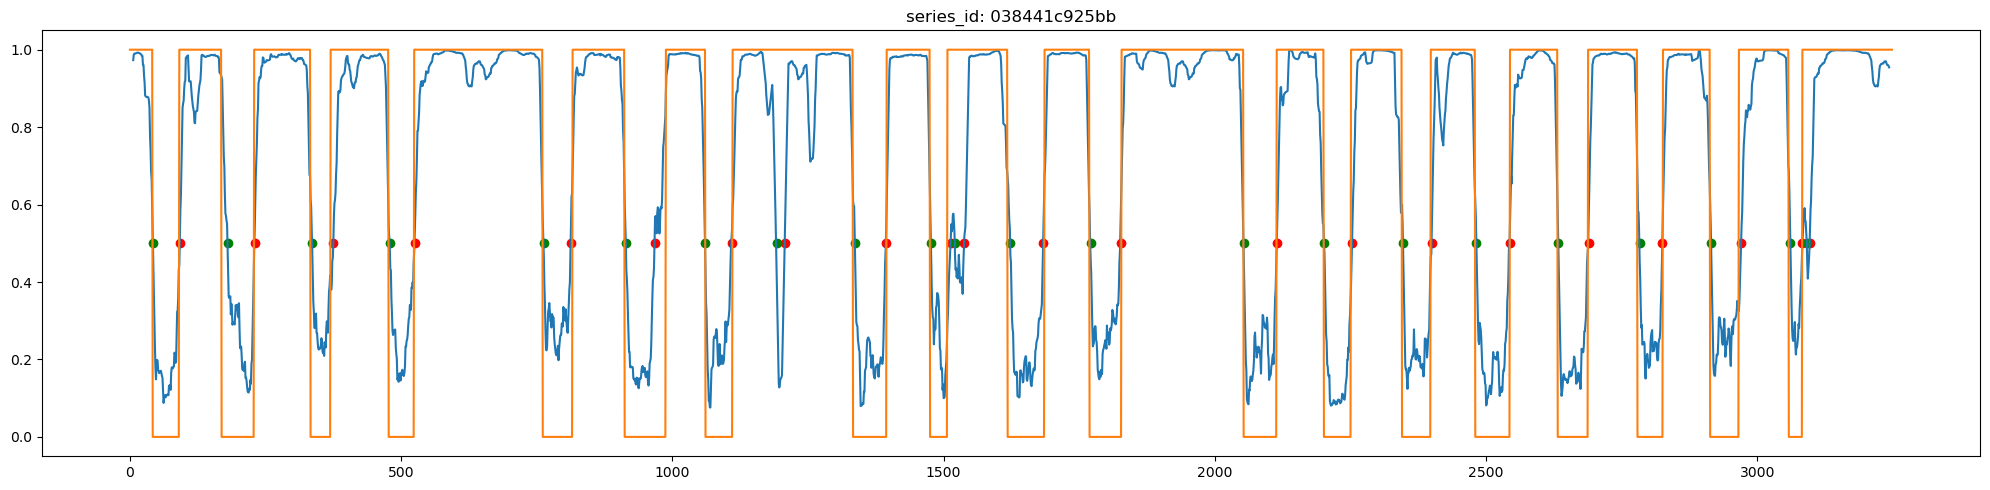

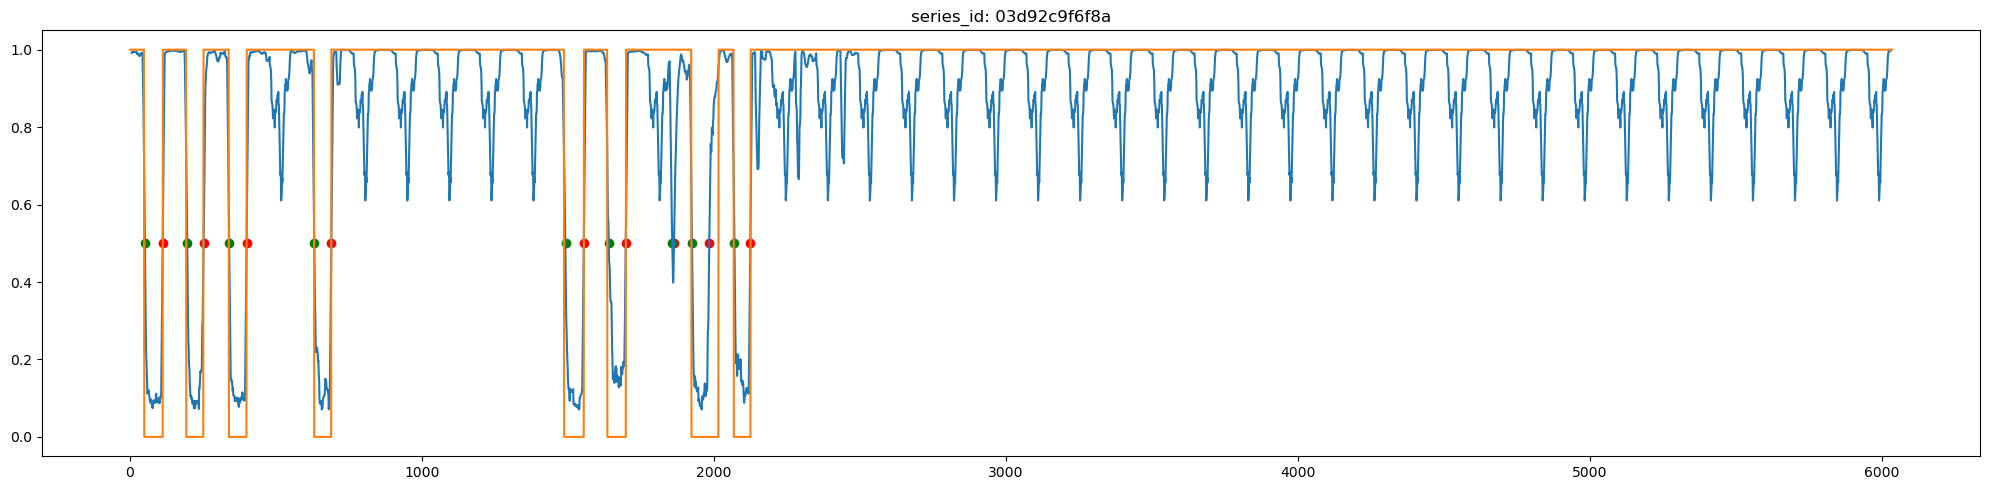

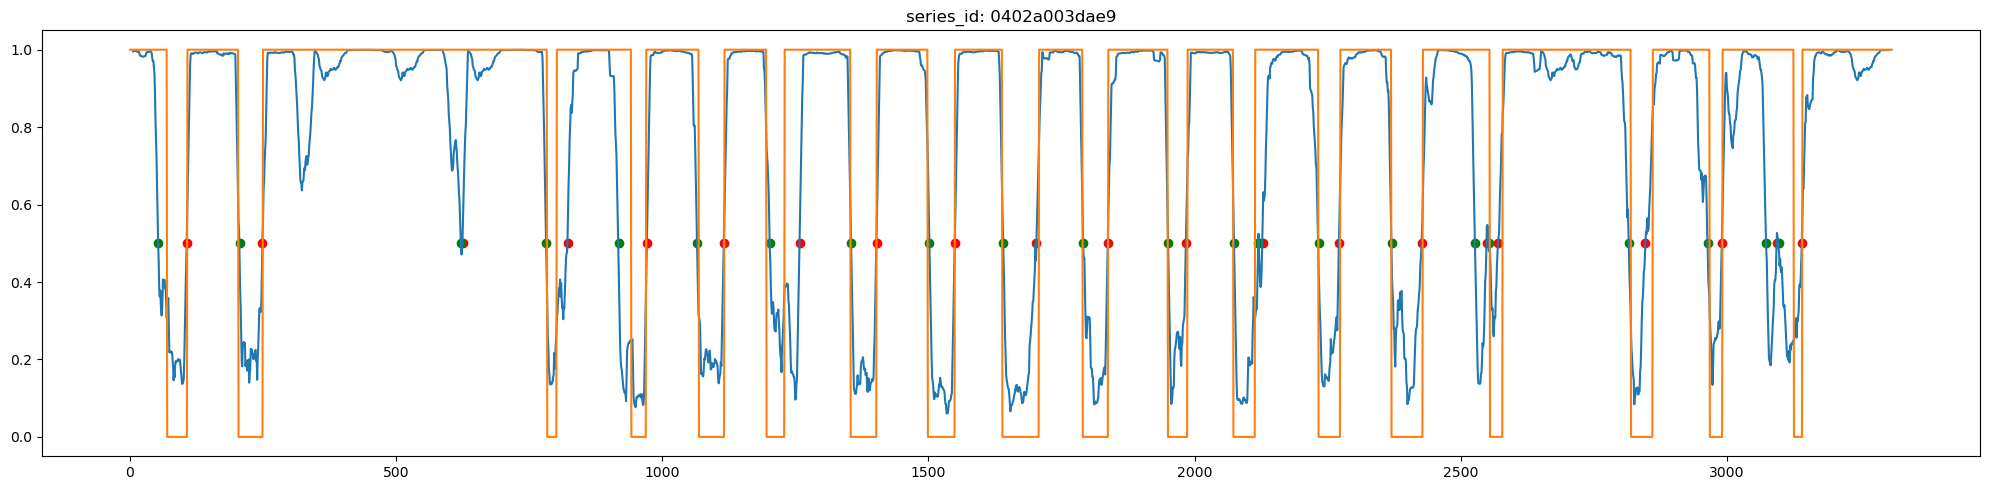

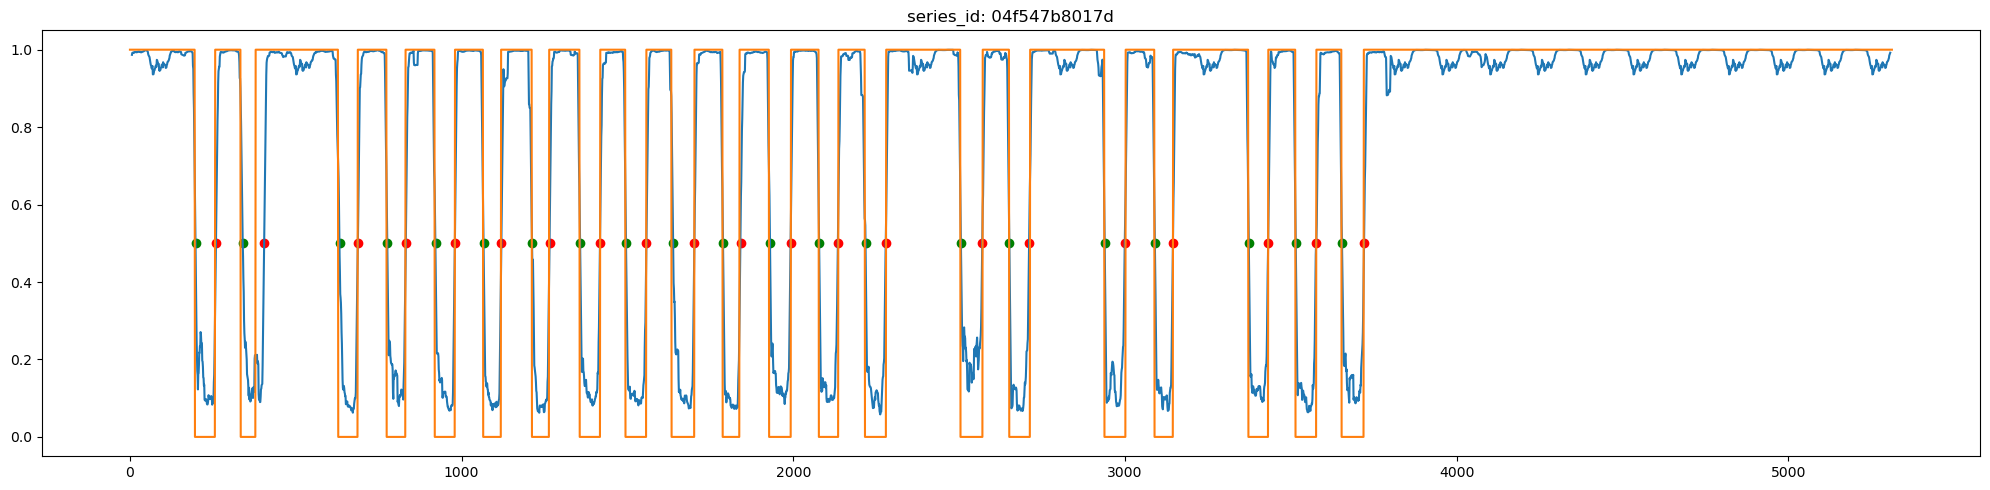

,series_id,step,event,score
0,038441c925bb,11099,wakeup,1
1,038441c925bb,27659,wakeup,1
2,038441c925bb,45059,wakeup,1
3,038441c925bb,63059,wakeup,1
4,038441c925bb,97619,wakeup,1


In [25]:
dfs = []
for series_id, df in train.groupby("series_id"):
    df = df.reset_index(drop=True)
    oof = df["oof"].rolling(12, center=True).mean()
    wakeup_index = [i for i in range(1, len(oof)) if oof[i-1] < 0.5 and oof[i] >= 0.5]
    onset_index = [i for i in range(1, len(oof)) if oof[i-1] > 0.5 and oof[i] <= 0.5]

    sub = pd.concat([
        pd.DataFrame({
            "series_id": series_id,
            "step": (df["step_min"].values[wakeup_index] + df["step_max"].values[wakeup_index]) // 2,
            "event": "wakeup",
            "score": 1,
        }),
        pd.DataFrame({
            "series_id": series_id,
            "step": (df["step_min"].values[onset_index] + df["step_max"].values[onset_index]) // 2,
            "event": "onset",
            "score": 1,
        }),
    ])
    dfs.append(sub)

    if len(dfs) < 5:
        plt.subplots(figsize=(20, 5))
        plt.plot(oof)
        plt.plot(df["target"])
        plt.scatter(wakeup_index, [0.5 for _ in wakeup_index], c="red")
        plt.scatter(onset_index, [0.5 for _ in onset_index], c="green")
        plt.title(f"series_id: {series_id}")
        plt.tight_layout()
        plt.show()

sub = pd.concat(dfs).reset_index(drop=True)
sub.head()

In [26]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()

score, ap_table = compute_comptetition_metric(labels, sub)
score

0.15348797046842283

In [28]:
ap_table

event   tolerance
onset   12           0.000202
        36           0.001619
        60           0.005422
        90           0.013050
        120          0.029267
        150          0.044184
        180          0.076834
        240          0.152348
        300          0.239351
        360          0.330682
wakeup  12           0.001211
        36           0.018605
        60           0.052666
        90           0.101803
        120          0.167290
        150          0.225351
        180          0.283705
        240          0.377083
        300          0.446127
        360          0.502963
dtype: float64

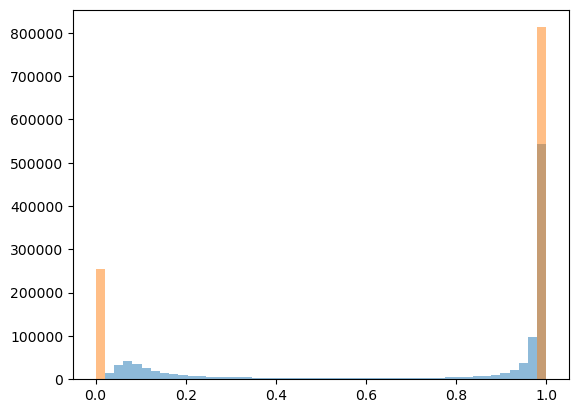

In [27]:
plt.hist(train["oof"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.show()